In [1]:
# if necessary install the missing libaries by using pip install.

# !pip3 install torch==1.10.0+cu102 torchvision==0.11.1+cu102 torchaudio===0.10.0+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html
# !pip install tqdm boto3 requests regex sentencepiece sacremoses
# !pip install huggingface_hub
# !pip install transformers
# !pip install h5py --upgrade --user

In [1]:
# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import *

# utilities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns

# helper functions
import utils

# global variables
RANDOM = 42
MAX_LEN = 150
BATCH_SIZE = 16
EPOCHS = 4
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

D:\Programs\anaconda\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


This Notebook was built using PyTorch version 1.10.0 with Cuda 10.2.
If the printout from the next code cell differs from `1.10.0+cu102` please note that the notebook might not run through proberly. Up- or Downgrade your Pytorch and Cuda Version accordingly.

In [2]:
torch.__version__

'1.10.0+cu102'

In [3]:
# see if gpu is available
print(f'GPU Available: ', torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU Available:  True


# IMDB Sentiment Analysis through BERT

> BERT: Bidirectional Encoder Representations from Transformers

This notebook aims to perform a sentiment analysis on the IMDB dataset using the BERT language model. BERT stands for Bidirectional Encoder Representations from Transformers and can be used for text classification or question & answering systems. The model was trained on the corpus of Wikipedia (2500 million words) and BookKorpus (800 million words) (see Jacob Devlin, 2018).

The IMDB dataset contains 50 thousand reviews each annotated with a sentiment (positive or negative). This sentiment is our target variable. Thus, in our case it is a supervised learning problem. Bert can also solve semi-supervised problems, such as predicting a masked word in a sentence (see Alammar, 2021). For the prediction of the sentiment, the same preprocessing is used as in the other two notebooks (Deepl Learning and baseline methods like TF-IDF or Bag-of-Words).

This notebook mostly follows the following blog post: [Sentiment Analysis with BERT using PyTorch](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

**Table of Contents:**

1. [Processing Dataset](#1)
2. [BERT Model](#2)
3. [Building Model Pipeline](#3)
4. [Training Model](#4)
5. [Model Evaluation](#6)
6. [Sources](#7)

### **1. Processing Dataset** <a class="anchor" id="1"></a>

In this chapter the dataset is loaded and prepared with the `preprocessor_text` function from the script `utils.py`. HTML tags are removed, brackets are removed, special character is removed and `Porter Stemmer` from `nltk` is applied. Stop words of the English language were also removed. If the data is not available you can download a csv [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews.)

In [4]:
df_imdb = pd.read_csv('data/IMDB Dataset.csv')
df_imdb.sample(3)

,review,sentiment
9353,"Miranda Cosgrove is known for her debut in ""Sc...",negative
13048,"I normally finish every movie or book I start,...",negative
41692,This cosy middle class sitcom became the subje...,negative


In [5]:
# TO DO: Check if preprocessing is even necessary. It seems to me that BERT should be trained on the raw Text.
def preprocess_data(df):
    """
    Checks if preprocessed data is available. If not: runs preprocessing on df and saves the processed data

    :param df: pd.DataFrame
    :return: df_prepped, Preprocessed DataFrame
    """
    path_prepro = Path('.\data\preprocessed_data\imdb_preprocessed.csv')

    if path_prepro.is_file():
        df_prepped = pd.read_csv(path_prepro)
        return df_prepped
    else:
        df_prepped = utils.preprocesser_text(df_imdb)
        df_prepped.to_csv(path_prepro)
        return df_prepped


df_prepped = preprocess_data(df_imdb)
df_prepped.sample(3)

,Unnamed: 0,review,sentiment
36858,36858,disagre previou comment thi movi think wa cute...,positive
22871,22871,ok deal love action movi gener problem suspend...,negative
43249,43249,truli great film stumbl onto video store rent ...,positive


In [6]:
# train test split
df_prepped.sentiment = utils.binarize_sentiment(df_prepped.sentiment)
df_prepped.sample(3)

,Unnamed: 0,review,sentiment
47562,47562,wa onli extra thi movi got see boston sold cin...,1
30179,30179,crimson river one overdirect overthetop overev...,0
24234,24234,first good movi pretti actress exot background...,0


In [7]:
df_train, df_test = utils.train_test_split(df_prepped)
df_train.sample(3)

,Unnamed: 0,review,sentiment
38754,38754,live japan awhil enjoy beauti thi movi live ok...,1
6782,6782,thi littl film big heart excel act throughout ...,1
6667,6667,watch mari mcdonnel perform close bodi languag...,1


In [8]:
print(f'Length Trainset: ', len(df_train))
print(f'Length Testset:  ', len(df_test))

Length Trainset:  40000
Length Testset:   10000


### **2. BERT Model** <a class="anchor" id="2"></a>


In [9]:
def get_bert(df):
    """
    Load pretrained bert model and corresponding preprocessor.
    Note: Input should be processed in the same way as the training data for the model

    :return: None
    """
    # load bert model for sequence classification
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

    model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    return {'tokenizer': tokenizer, 'model': model}


BERT = get_bert(df_prepped)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


C:\Users\stude\AppData\Local\Temp/ipykernel_17288/1207032622.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for r in tqdm_notebook(df_prepped.review):


  0%|          | 0/50000 [00:00<?, ?it/s]

TypeError: file must have a 'write' attribute

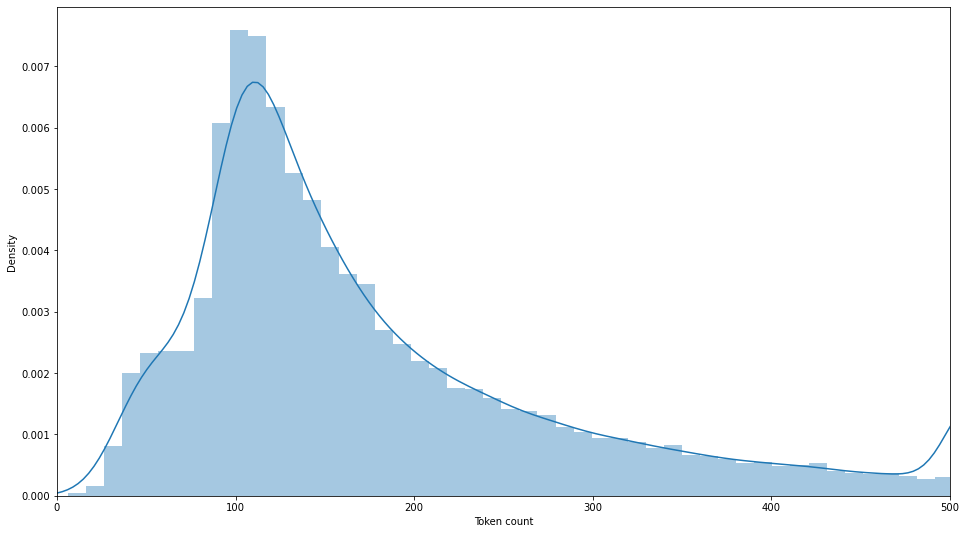

In [10]:
import pickle
plot_path = Path('.\graphs\max_len.pkl')

if plot_path.is_file():
    ax = pickle.load(plot_path)
    plt.show()

else:
    plt.figure(figsize=(16, 9))
    token_lens = []
    for r in tqdm_notebook(df_prepped.review):
        tokens = BERT['tokenizer'].encode(r, max_length=512, truncation=True)
        token_lens.append(len(tokens))
    ax = sns.distplot(token_lens)
    plt.xlim([0, 500])
    plt.xlabel('Token count')
    pickle.dump(ax, plot_path)
    plt.show()

In [12]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = BERT['tokenizer'].tokenize(sample_txt)
token_ids = BERT['tokenizer'].convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [13]:
class IMDBDataset(Dataset):
    """

    """
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        """

        :param reviews:
        :param sentiments:
        :param tokenizer:
        :param max_len:
        """
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """

        :return:
        """
        return len(self.reviews)

    def __getitem__(self, item):
        """

        :param item:
        :return:
        """
        review = str(self.reviews[item])
        sentiment = self.sentiments[item]

        encoding = self.tokenizer.encode_plus(
            review,
            max_length=16,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            pad_to_max_length=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiments': torch.tensor(sentiment, dtype=torch.long)
        }


def create_loader(df, tokenizer, max_len, batch_size):
    """

    :param df:
    :param tokenizer:
    :param max_len:
    :param batch_size:
    :return:
    """
    ds = IMDBDataset(
        reviews=df.review.to_numpy(),
        sentiments=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=4)


train_data_loader = create_loader(df_train, BERT['tokenizer'], MAX_LEN, BATCH_SIZE)
test_data_loader = create_loader(df_test, BERT['tokenizer'], MAX_LEN, BATCH_SIZE)

In [ ]:
%time data = next(iter(test_data_loader)).to(device)
data.keys()

In [ ]:
class IMDBClassifier(nn.Module):
    """

    """

    def __init__(self, n_classes, model):
        """

        :param n_classes:
        :param model:
        """
        super(IMDBClassifier, self).__init__()
        self.bert = model['model'].from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """

        :param input_ids:
        :param attention_mask:
        :return:
        """
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)


model = IMDBClassifier(len(df_prepped.sentiment.unique()), BERT)
model = model.to(device)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """

    :param model:
    :param data_loader:
    :param loss_fn:
    :param optimizer:
    :param device:
    :param scheduler:
    :param n_examples:
    :return:
    """
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        sentiments = d["sentiments"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, sentiments)

        correct_predictions += torch.sum(preds == sentiments)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    """

    :param model:
    :param data_loader:
    :param loss_fn:
    :param device:
    :param n_examples:
    :return:
    """
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            sentiments = d["sentiments"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, sentiments)

            correct_predictions += torch.sum(preds == sentiments)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
train_a = []
train_l = []
test_a = []
test_l = []
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    test_acc, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )

    print(f'Test   loss {test_loss} accuracy {test_acc}')
    print()

    train_a.append(train_acc)
    train_l.append(train_loss)
    test_a.append(test_acc)
    test_l.append(test_loss)

    if test_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = test_acc

In [ ]:
plt.plot(train_a, label='train accuracy')
plt.plot(test_a, label='test accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()